In [3]:
!pip install torch torchvision torchaudio
!pip install shap
!pip install scikit-learn
!pip install tqdm openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.0 MB/s eta 0:00:00 0:00:01


In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import openpyxl


In [ ]:
'''
Add code to reconstruct from scratch the dataset

'''

In [27]:
# ------------------------ Load, Process, and Save Data ------------------------

#Define Paths - CHANGE per run
in_path = r'C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Input'
out_path = r'C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output'


# Load US Preprocessed Data
bloomberg_df = pd.read_excel(in_path + '\Bloomberg\dataset bloomberg.xlsx', index_col=0, parse_dates=True)
Y_df = bloomberg_df.iloc[:-1,-6:]
X_df = bloomberg_df.iloc[:-1,:-6]

# Load US macroeconomic data
us_economic_directory = "C:\\Users\\azorb\\PycharmProjects\\Thesis\\Input Data\\US\\50Y"
additional_data = load_input(us_economic_directory, "1990-01-02")

X_df = X_df.merge(additional_data, left_index=True, right_index=True)

# Save Data
X_df.to_csv(out_path + '\Independent\X_df.csv')
Y_df.to_csv(out_path + '\Dependent\Y_df.csv')


C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\data_functions.py:96: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['observation_date'] = pd.to_datetime(
C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\data_functions.py:96: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['observation_date'] = pd.to_datetime(
C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\data_functions.py:96: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['observation_date'] = pd.to_datetime(
C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\data_functions.py:96: UserWarning: Parsing dates in %Y-%m-%d format 

In [69]:
# Compute delta for different horizons
Y_df_changes = compute_y_df_changes(Y_df)

# Compute directional binary indicators
Y_df_direction = compute_change_directions(Y_df)

horizons = [1,21,63,252]


for horizon in horizons:
    globals()[f'Y_df_change_{horizon}'] = Y_df_changes[f'Y_df_change_{horizon}']
    globals()[f'Y_df_change_dir_{horizon}'] = Y_df_direction[f'Y_df_change_{horizon}']
    Y_df_changes[f'Y_df_change_{horizon}'].to_csv(out_path + f'\Dependent\Changes\Y_df_change_{horizon}.csv')
    Y_df_direction[f'Y_df_change_{horizon}'].to_csv(out_path + f'\Dependent\Classification\Y_df_change_dir_{horizon}.csv')
    for col in Y_df_direction[f'Y_df_change_{horizon}'].columns:
        X_df[f'Y_df_change_dir_{horizon}_{col}'] = Y_df_direction[f'Y_df_change_{horizon}'][col]
        X_df[f'Y_df_change_{horizon}_{col}'] = Y_df_changes[f'Y_df_change_{horizon}'][col]

X_df.dropna(inplace=True)

# Find common dates
common_idx = X_df.index.intersection(Y_df.index)

# Align both datasets to those dates
X_df = X_df.loc[common_idx].copy()
Y_df = Y_df.loc[common_idx].copy()

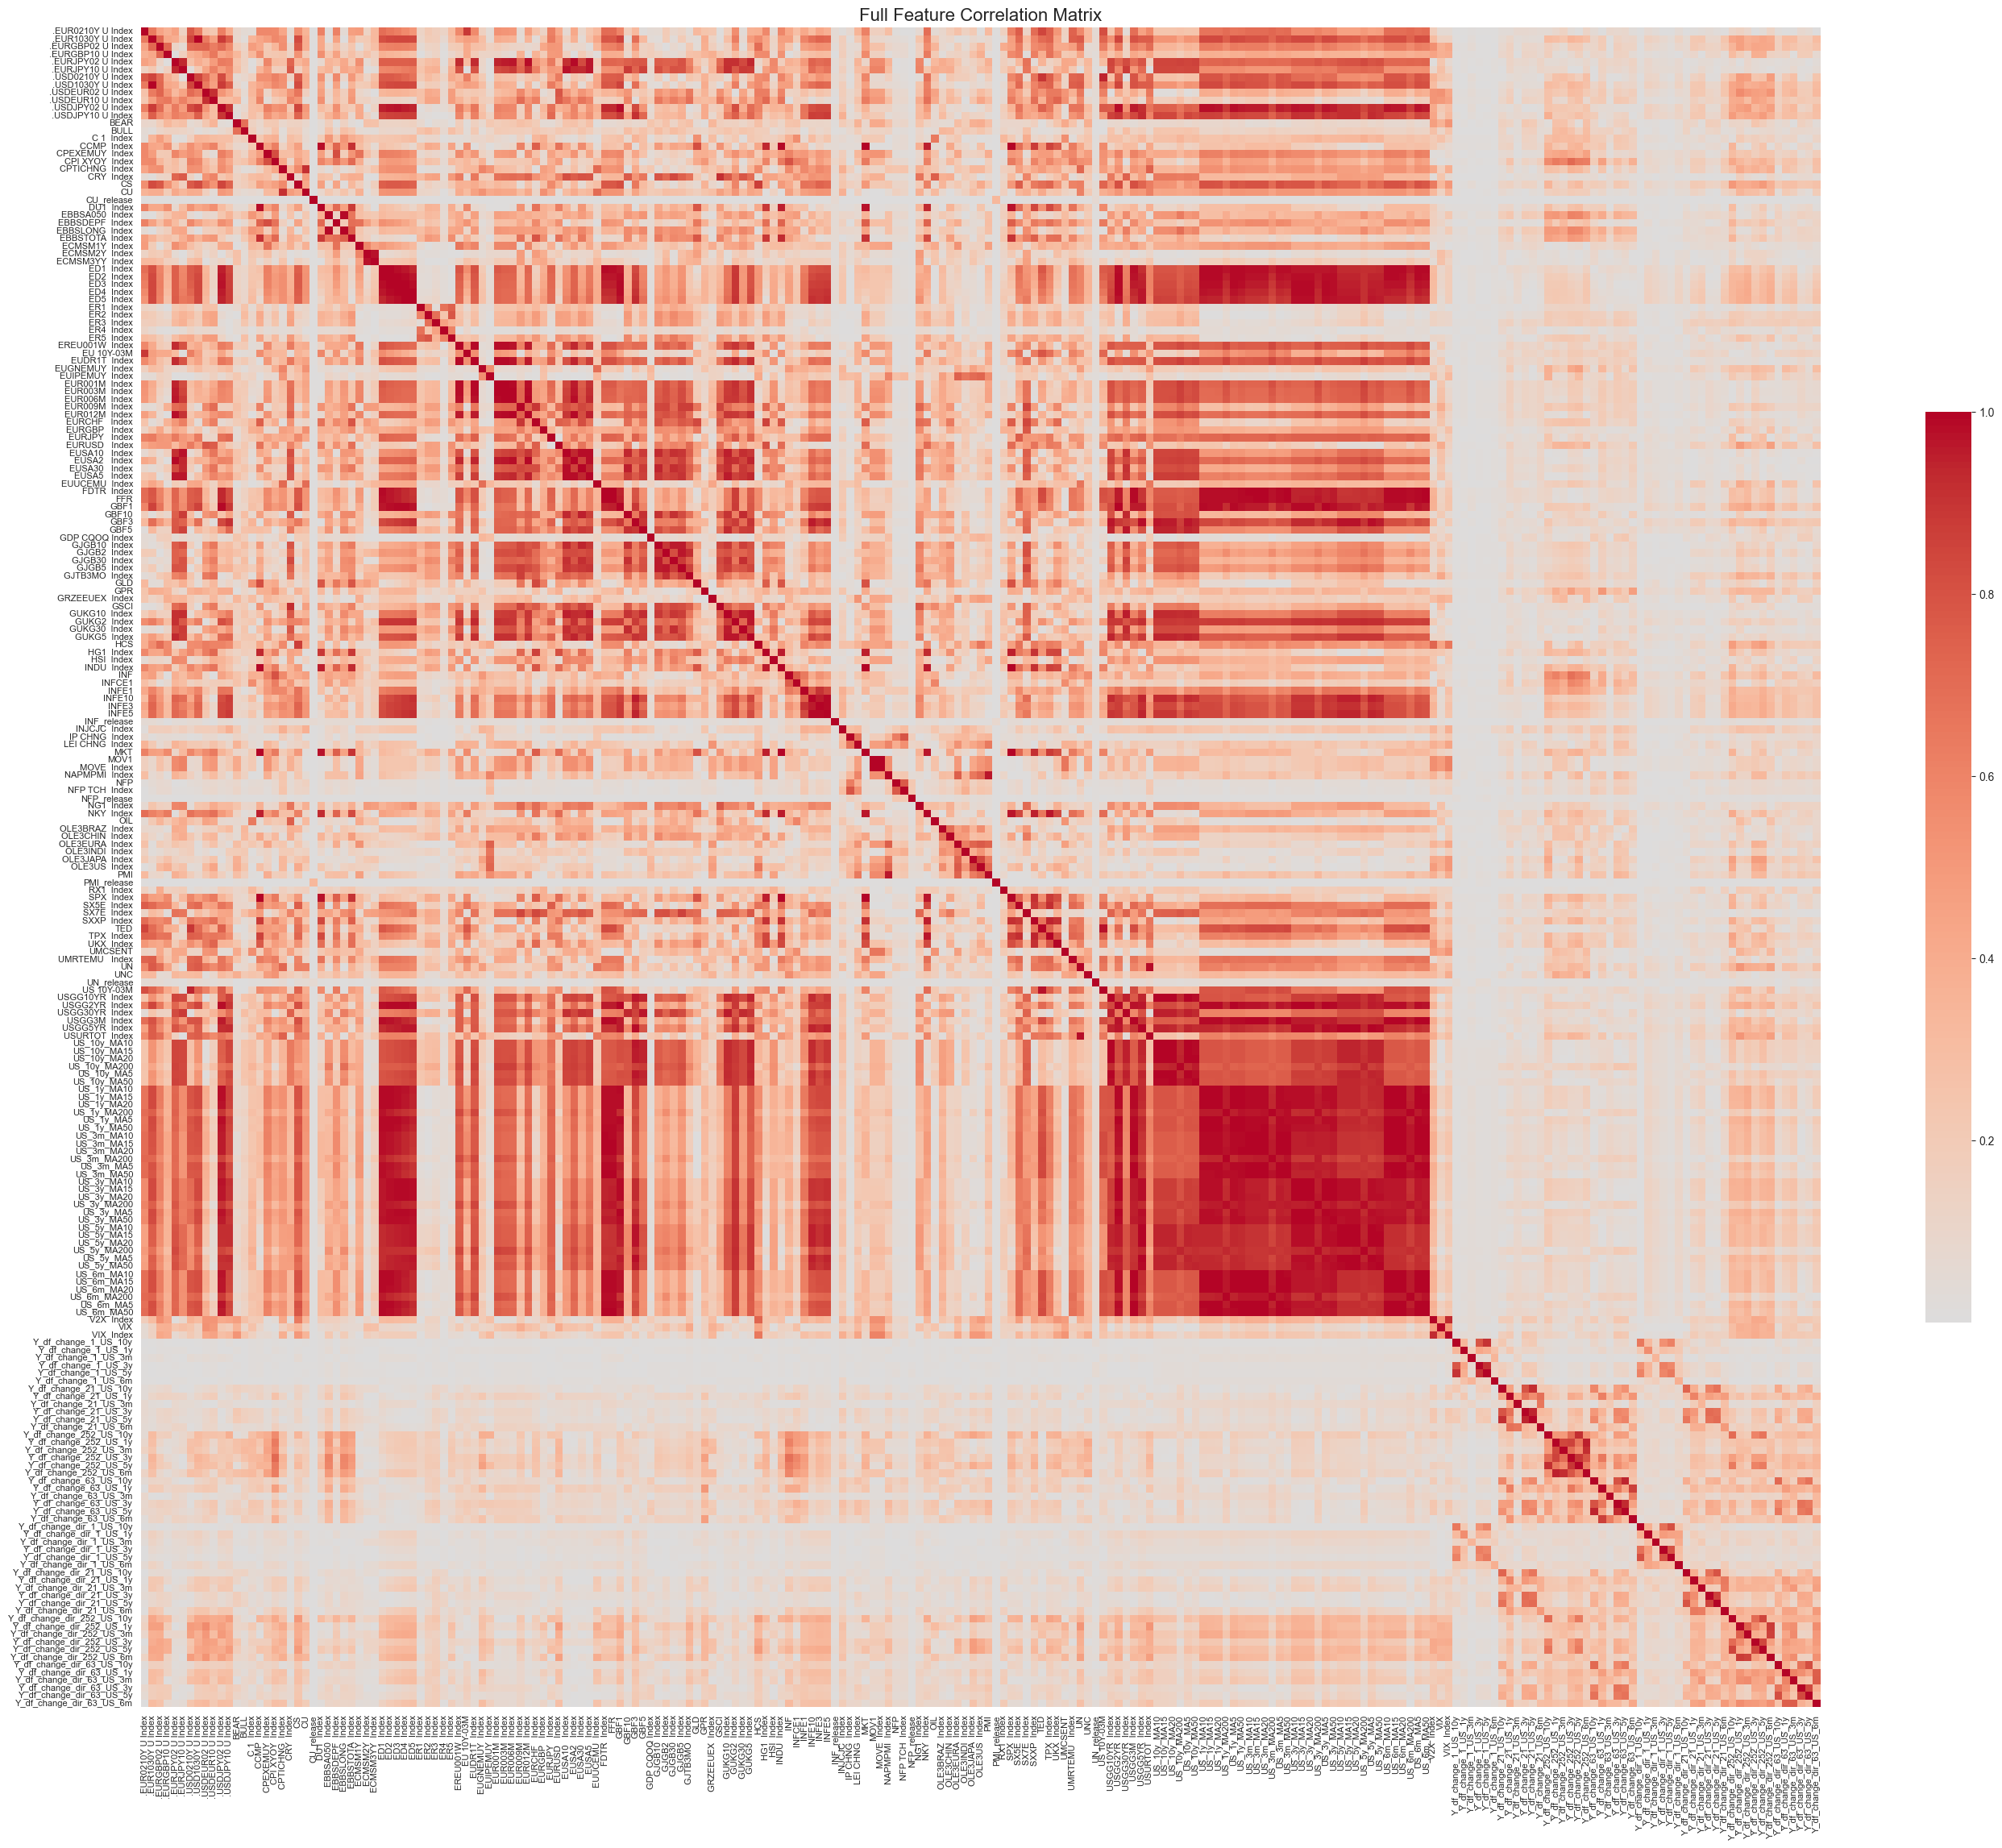

[INFO] Removed 106 highly correlated features (correlation > 0.9)
[INFO] Remaining features: 113


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

def remove_highly_correlated_features(X_df, threshold=0.95, plot=False):
    # Step 1: Compute absolute correlation matrix
    corr_matrix = X_df.corr().abs()

    # Step 2: Upper triangle mask to ignore self-correlation
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Step 3: Identify columns with high correlation
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Step 4: Optionally visualize
    if plot:
        sorted_cols = sorted(corr_matrix.columns)
        sorted_corr = corr_matrix.loc[sorted_cols, sorted_cols]

        plt.figure(figsize=(28, 24))  # Increased size
        sns.heatmap(
            sorted_corr,
            cmap='coolwarm',
            center=0,
            annot=False,
            fmt='.2f',
            square=True,
            xticklabels=True,
            yticklabels=True,
            cbar_kws={"shrink": 0.5}
        )
        plt.xticks(rotation=90, fontsize=8)
        plt.yticks(fontsize=8)
        plt.title("Full Feature Correlation Matrix", fontsize=16)
        plt.tight_layout()
        plt.show()

    # Step 5: Drop redundant columns
    X_df_filtered = X_df.drop(columns=to_drop)

    print(f"[INFO] Removed {len(to_drop)} highly correlated features (correlation > {threshold})")
    print(f"[INFO] Remaining features: {X_df_filtered.shape[1]}")
    return X_df_filtered

# Example usage
X_df_filtered = remove_highly_correlated_features(X_df, threshold=0.9, plot=True)

In [37]:
X_df_filtered.to_csv(r'C:\Users\azorb\PycharmProjects\Predicting the Yield Curve\Data Processing\Output\Independent\X_df_filtered.csv')
X_df_filtered

,EUDR1T Index,EUR009M Index,ER1 Index,ER2 Index,ER3 Index,ER4 Index,ER5 Index,FDTR Index,GJTB3MO Index,DU1 Index,...,Y_df_change_dir_63_US_10y,Y_df_change_dir_252_US_3m,Y_df_change_252_US_3m,Y_df_change_dir_252_US_6m,Y_df_change_dir_252_US_1y,Y_df_change_dir_252_US_3y,Y_df_change_252_US_3y,Y_df_change_dir_252_US_5y,Y_df_change_252_US_5y,Y_df_change_dir_252_US_10y
2004-09-13,2.0375,2.302,400.0,203,185,405,505,1.5,0.0090,31.10,...,0,1,0.765957,1,1,1,0.322430,1,0.108197,1
2004-09-14,2.0375,2.298,430.0,203,185,405,505,1.5,0.0080,30.85,...,0,1,0.765957,1,1,1,0.364078,1,0.135593,1
2004-09-15,2.0375,2.289,440.0,203,185,405,505,1.5,0.0080,30.15,...,0,1,0.739583,1,1,1,0.371981,1,0.137584,1
2004-09-16,2.0475,2.304,440.0,203,185,405,505,1.5,0.0080,29.70,...,0,1,0.757895,1,1,1,0.410256,1,0.154386,1
2004-09-17,2.0375,2.288,440.0,203,185,405,505,1.5,0.0080,29.95,...,0,1,0.800000,1,1,1,0.466321,1,0.179577,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-27,2.6500,-0.194,185.0,391,564,635,660,4.5,0.3000,294.60,...,1,0,-0.211679,0,0,0,-0.064665,0,-0.014458,1
2025-02-28,2.7202,-0.194,185.0,391,564,635,660,4.5,0.3300,293.60,...,1,0,-0.211679,0,0,0,-0.086957,0,-0.038186,1
2025-03-03,2.7200,-0.194,185.0,391,564,635,660,4.5,0.3353,283.50,...,0,0,-0.206204,0,0,0,-0.118834,0,-0.074592,0
2025-03-04,2.6974,-0.194,185.0,391,564,635,660,4.5,0.3403,278.50,...,1,0,-0.208029,0,0,0,-0.126386,0,-0.073903,0


In [29]:
# ---------------------- Imports ---------------------- #
import pandas as pd
import numpy as np
import shap
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tqdm import tqdm
import time
import os

# ---------------------- Reproducibility ---------------------- #
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# ---------------------- MLP Model ---------------------- #
class YieldMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

# ---------------------- SHAP Evaluation ---------------------- #
def run_shap_mlp_tabular(X_df, Y_df, hidden_dim=64, n_folds=5, background_size=100, val_sample_size=150):
    assert len(X_df) == len(Y_df)
    common_idx = X_df.index.intersection(Y_df.index)
    X_df, Y_df = X_df.loc[common_idx], Y_df.loc[common_idx]

    input_dim = X_df.shape[1]
    output_dim = Y_df.shape[1]
    shap_results = {f'maturity_{i+1}': np.zeros(input_dim) for i in range(output_dim)}

    kf = KFold(n_splits=n_folds, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_df)):
        X_train, Y_train = X_df.iloc[train_idx], Y_df.iloc[train_idx]
        X_val, Y_val = X_df.iloc[val_idx], Y_df.iloc[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        Y_train_t = torch.tensor(Y_train.values, dtype=torch.float32).to(device)
        X_val_t = torch.tensor(X_val_scaled[:val_sample_size], dtype=torch.float32).to(device)
        background_data = X_train_t[:background_size]

        for maturity_idx in range(output_dim):
            model = YieldMLP(input_dim, hidden_dim, 1).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.MSELoss()

            model.train()
            for _ in range(10):
                optimizer.zero_grad()
                output = model(X_train_t)
                loss = criterion(output.squeeze(), Y_train_t[:, maturity_idx])
                loss.backward()
                optimizer.step()

            model.eval()
            explainer = shap.DeepExplainer(model, background_data)
            print(f"[INFO] Running SHAP for maturity {maturity_idx+1} (fold {fold+1})")
            start_time = time.time()
            shap_vals = explainer.shap_values(X_val_t, check_additivity=False)
            print(f"[TIMER] SHAP maturity {maturity_idx+1}, fold {fold+1} took {time.time() - start_time:.2f} seconds")

            if isinstance(shap_vals, list):
                shap_vals = shap_vals[0]

            print(f"[DEBUG] SHAP shape: {shap_vals.shape}, input_dim: {input_dim}")

            if shap_vals.shape[0] != val_sample_size or shap_vals.shape[1] != input_dim:
                raise ValueError(f"Unexpected SHAP output shape: {shap_vals.shape}")

                
            mean_vals = np.abs(shap_vals).mean(axis=0).flatten()
            print(f"[DEBUG] mean_vals shape: {mean_vals.shape}")
            shap_results[f'maturity_{maturity_idx+1}'] += mean_vals / n_folds

    return pd.DataFrame(shap_results, index=X_df.columns)

# ---------------------- Run All SHAP ---------------------- #
def run_all_shap():
    base_path = "./"
    forecast_horizons = [1, 5, 21, 63, 252]
    for h in forecast_horizons:
        print(f"[INFO] Running SHAP for horizon {h}")
        X_df = pd.read_csv(f"X_df_filtered.csv", index_col=0, parse_dates=True)
        Y_df = pd.read_csv(f"Y_df_change_dir_{h}.csv", index_col=0, parse_dates=True)

        # Clean and align
        X_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_df.dropna(inplace=True)

        common_idx = X_df.index.intersection(Y_df.index)
        X_df = X_df.loc[common_idx]
        Y_df = Y_df.loc[common_idx]

        assert len(X_df) == len(Y_df), f"Mismatch: X_df={len(X_df)}, Y_df={len(Y_df)}"

        print(f"X_df shape: {X_df.shape}")
        print(f"Y_df shape: {Y_df.shape}")

        shap_df = run_shap_mlp_tabular(X_df, Y_df)

        output_dir = os.path.join(base_path, "SHAP")
        os.makedirs(output_dir, exist_ok=True)
        shap_df.to_csv(os.path.join(output_dir, f"shap_df_h{h}.csv"))

if __name__ == "__main__":
    run_all_shap()

[INFO] Running SHAP for horizon 1
X_df shape: (5255, 113)
Y_df shape: (5255, 6)
[INFO] Running SHAP for maturity 1 (fold 1)
[TIMER] SHAP maturity 1, fold 1 took 0.64 seconds
[DEBUG] SHAP shape: (150, 113, 1), input_dim: 113
[DEBUG] mean_vals shape: (113,)
[INFO] Running SHAP for maturity 2 (fold 1)
[TIMER] SHAP maturity 2, fold 1 took 0.68 seconds
[DEBUG] SHAP shape: (150, 113, 1), input_dim: 113
[DEBUG] mean_vals shape: (113,)
[INFO] Running SHAP for maturity 3 (fold 1)
[TIMER] SHAP maturity 3, fold 1 took 0.67 seconds
[DEBUG] SHAP shape: (150, 113, 1), input_dim: 113
[DEBUG] mean_vals shape: (113,)
[INFO] Running SHAP for maturity 4 (fold 1)
[TIMER] SHAP maturity 4, fold 1 took 0.67 seconds
[DEBUG] SHAP shape: (150, 113, 1), input_dim: 113
[DEBUG] mean_vals shape: (113,)
[INFO] Running SHAP for maturity 5 (fold 1)
[TIMER] SHAP maturity 5, fold 1 took 0.66 seconds
[DEBUG] SHAP shape: (150, 113, 1), input_dim: 113
[DEBUG] mean_vals shape: (113,)
[INFO] Running SHAP for maturity 6 (fold

In [25]:
def run_all_shap():
    horizons = [1, 5, 21, 63, 252]
    base_path = "Output"
    for h in horizons:
        print(f"[INFO] Running SHAP for horizon {h}")
        X_df = pd.read_csv("X_df_filtered.csv", index_col=0, parse_dates=True)
        Y_df = pd.read_csv(f"Y_df_change_dir_{h}.csv", index_col=0, parse_dates=True)

        # Clean and align
        X_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        X_df.dropna(inplace=True)

        # Align both datasets after cleaning
        common_idx = X_df.index.intersection(Y_df.index)
        X_df = X_df.loc[common_idx]
        Y_df = Y_df.loc[common_idx]

        # Final assert to ensure alignment
        assert len(X_df) == len(Y_df), f"Mismatch: X_df={len(X_df)}, Y_df={len(Y_df)}"

        # Print shapes
        print(f"X_df shape: {X_df.shape}")
        print(f"Y_df shape: {Y_df.shape}")

        shap_df = run_shap_lstm_ts_cv(X_df, Y_df, forecast_horizon=h)

        output_dir = os.path.join(base_path, "SHAP")
        os.makedirs(output_dir, exist_ok=True)
        shap_df.to_csv(os.path.join(output_dir, f"shap_df_h{h}.csv"))

if __name__ == "__main__":
    run_all_shap()


[INFO] Running SHAP for horizon 1
X_df shape: (5255, 113)
Y_df shape: (5255, 6)
[DEBUG] Columns with Inf values: []
[DEBUG] Checking for NaNs or Infs in X_train before scaling (fold 0)
[DEBUG] No NaNs or Infs detected in X_train
[DEBUG] Columns with Inf values: []
[DEBUG] Checking for NaNs or Infs in X_train before scaling (fold 1)
[DEBUG] No NaNs or Infs detected in X_train
[DEBUG] Columns with Inf values: []
[DEBUG] Checking for NaNs or Infs in X_train before scaling (fold 2)
[DEBUG] No NaNs or Infs detected in X_train
[DEBUG] Columns with Inf values: []
[DEBUG] Checking for NaNs or Infs in X_train before scaling (fold 3)
[DEBUG] No NaNs or Infs detected in X_train
[DEBUG] Columns with Inf values: []
[DEBUG] Checking for NaNs or Infs in X_train before scaling (fold 4)
[DEBUG] No NaNs or Infs detected in X_train
[INFO] Running SHAP for maturity 1... this may take a few minutes
[TIMER] SHAP maturity 1 took 10.29 seconds


ValueError: Unexpected SHAP output shape: (150, 252, 113, 1)

In [15]:
shap_df['Total Feature Importance'] = shap_df.sum(axis=1)
shap_df.sort_values('Total Feature Importance', ascending=False, inplace=True)

shap_df

[INFO] Processing SHAP for horizon: 1d


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\azorb\\PycharmProjects\\Predicting the Yield Curve\\Data Processing\\Output\\SHAP\\shap_df_1d.csv'

In [116]:
shap_df.loc[:,'Total Feature Importance']

In [20]:
X_df = pd.read_csv("X_df_filtered.csv", index_col=0, parse_dates=True)
X_df.columns

Index(['EUDR1T  Index', 'EUR009M  Index', 'ER1  Index', 'ER2  Index',
       'ER3  Index', 'ER4  Index', 'ER5  Index', 'FDTR  Index',
       'GJTB3MO  Index', 'DU1  Index',
       ...
       'Y_df_change_dir_63_US_10y', 'Y_df_change_dir_252_US_3m',
       'Y_df_change_252_US_3m', 'Y_df_change_dir_252_US_6m',
       'Y_df_change_dir_252_US_1y', 'Y_df_change_dir_252_US_3y',
       'Y_df_change_252_US_3y', 'Y_df_change_dir_252_US_5y',
       'Y_df_change_252_US_5y', 'Y_df_change_dir_252_US_10y'],
      dtype='object', length=113)